In [1]:
from fileio import load_opt_path_bitmaps
SLURM_ID = 128762
HIDDEN_SIZES = [10, 25, 100]
NUM_RUNS = 100
NUM_OPT_POINTS = 11

In [2]:
from fileio import load_opt_path_bitmaps, load_fine_path_train_bitmaps, load_fine_path_test_bitmaps
def get_opt_paths(num_hidden, num_runs=NUM_RUNS, slurm_id=SLURM_ID, include_fine=False): 
    train_opt_path, test_opt_path = load_opt_path_bitmaps(num_hidden, 0, slurm_id)
    num_opt_points = len(train_opt_path)
    train_opt_paths = [[] for _ in range(num_opt_points)]
    test_opt_paths = [[] for _ in range(num_opt_points)]
    
    for i in range(num_runs):
        train_opt_path, test_opt_path = load_opt_path_bitmaps(num_hidden, i, slurm_id)
        for j in range(num_opt_points):
            train_opt_paths[j].append(train_opt_path[j])
            test_opt_paths[j].append(test_opt_path[j])
            
    if include_fine:
        fine_train_path = []
        fine_test_path = []
        for i in range(10):
            fine_train_path.append([load_fine_path_train_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)])
            fine_test_path.append([load_fine_path_test_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)])
        train_opt_paths = train_opt_paths[:1] + fine_train_path + train_opt_paths[1:]
        test_opt_paths = test_opt_paths[:1] + fine_test_path + test_opt_paths[1:]
        
    return train_opt_paths, test_opt_paths

In [3]:
import torch

def get_probs(bitmaps_list, idxs=None, sort=False):
    bitmaps = torch.cat(bitmaps_list, dim=1)
    ps = torch.mean(bitmaps, dim=1)
    if sort:
        return torch.sort(ps)
    elif idxs is not None:
        return ps[idxs]
    elif idxs is None:
        return ps
    else:
        raise ValueError('Invalid argument combination: idxs={} with sort={}'.format(idxs, sort))

In [4]:
train_opt_paths, test_opt_paths = get_opt_paths(25, NUM_RUNS, SLURM_ID, include_fine=True)

In [4]:
import numpy as np
from math import sqrt
from infmetrics import get_pairwise_hamming_diffs
def get_mean_std_hamm_diffs(opt_paths, non_id=True):
    n_indep = len(opt_paths[0])
    means = []
    stds = []
    for i in range(len(train_opt_paths)):
        if non_id:
            ps = get_probs(opt_paths[i])
            dists, _ = get_pairwise_hamming_diffs(opt_paths[i], ps=ps)
        else:
            dists, _ = get_pairwise_hamming_diffs(opt_paths[i])
        means.append(np.mean(dists))
        stds.append(np.std(dists) / sqrt(n_indep))
    return means, stds

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_errorbars(means, stds, title, label, include_fine=False):
    if include_fine:
        x = [0] + [i / 10 for i in range(1, 11)] + list(range(1, 11))
    else:
        x = list(len(means))
    plt.title(title)
    print('len(x):', len(x))
    print('len(means):', len(means))
    plt.errorbar(x, means, yerr=[2 * std for std in stds], capsize=5, label=label)
    plt.xlabel('epoch')
    plt.ylabel('mean hamming distance (subtracted expectation)')

len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21


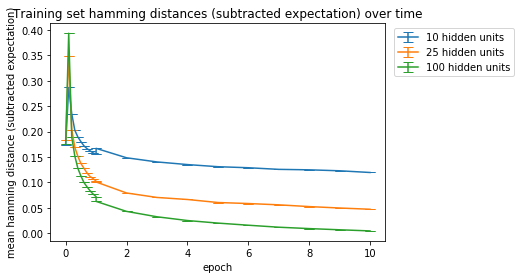

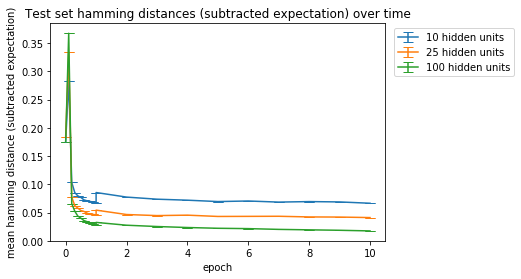

In [8]:
# Without identically distributed assumption, just plotting the expectation
for num_hidden in HIDDEN_SIZES:
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, NUM_RUNS, SLURM_ID, include_fine=True)
    
    means, stds = get_mean_std_hamm_diffs(train_opt_paths)
    plt.figure('train')
    plot_errorbars(means, stds, 'Training set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    means, stds = get_mean_std_hamm_diffs(test_opt_paths)
    plt.figure('test')
    plot_errorbars(means, stds, 'Test set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21


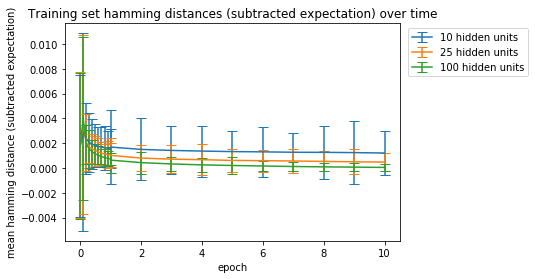

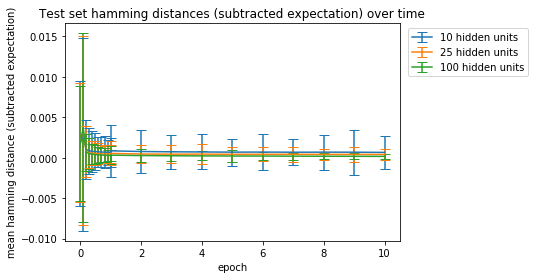

In [6]:
# Without identically distributed assumption
for num_hidden in HIDDEN_SIZES:
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, NUM_RUNS, SLURM_ID, include_fine=True)
    
    means, stds = get_mean_std_hamm_diffs(train_opt_paths)
    plt.figure('train')
    plot_errorbars(means, stds, 'Training set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    means, stds = get_mean_std_hamm_diffs(test_opt_paths)
    plt.figure('test')
    plot_errorbars(means, stds, 'Test set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21
len(x): 21
len(means): 21


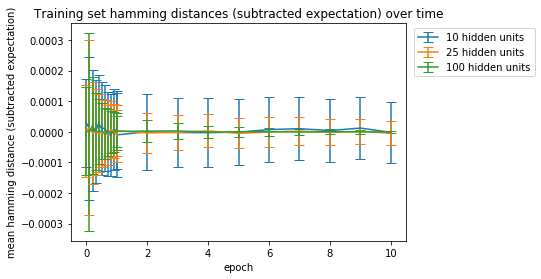

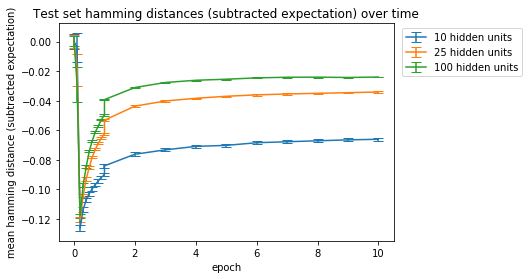

In [13]:
# With identically distributed assumption
for num_hidden in HIDDEN_SIZES:
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, NUM_RUNS, SLURM_ID, include_fine=True)
    
    means, stds = get_mean_std_hamm_diffs(train_opt_paths, non_id=False)
    plt.figure('train')
    plot_errorbars(means, stds, 'Training set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    means, stds = get_mean_std_hamm_diffs(test_opt_paths, non_id=False)
    plt.figure('test')
    plot_errorbars(means, stds, 'Test set hamming distances (subtracted expectation) over time',
                   '{} hidden units'.format(num_hidden), include_fine=True)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

In [3]:
def opt_paths_to_ordered_ps(opt_paths):
    _, idxs = get_probs(opt_paths[1], sort=True)
    return [get_probs(opt_points_i, idxs) for opt_points_i in opt_paths]

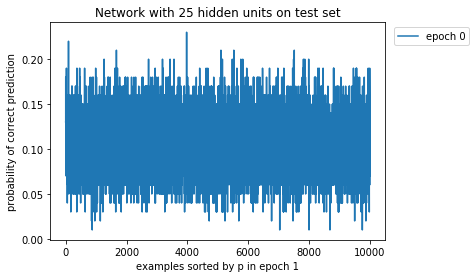

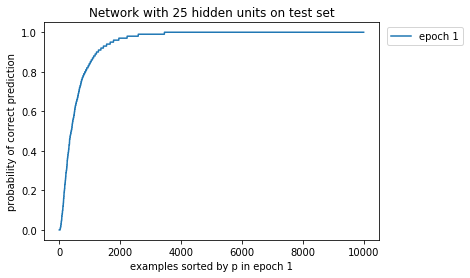

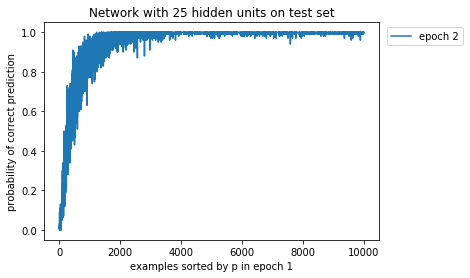

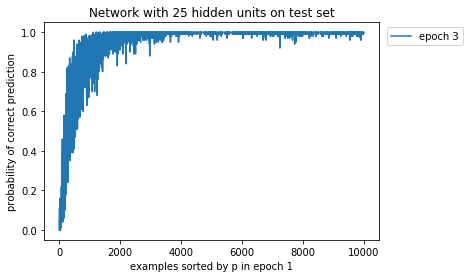

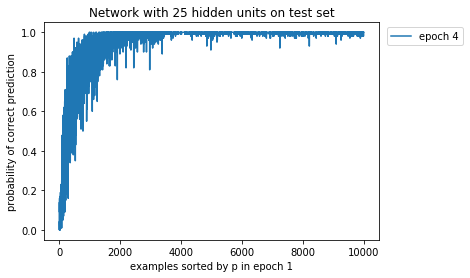

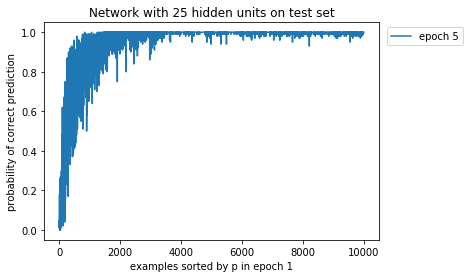

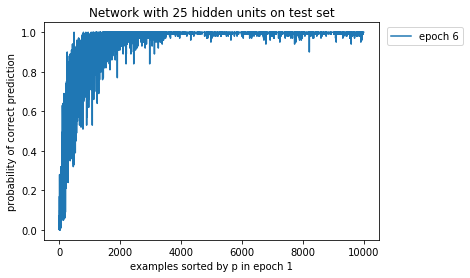

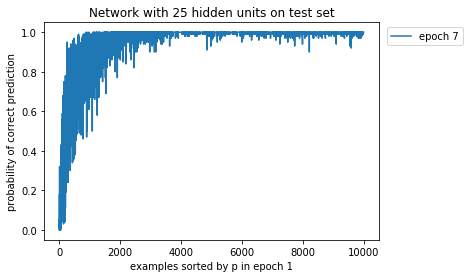

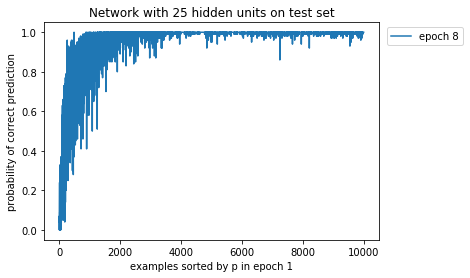

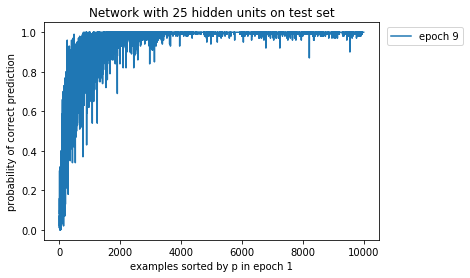

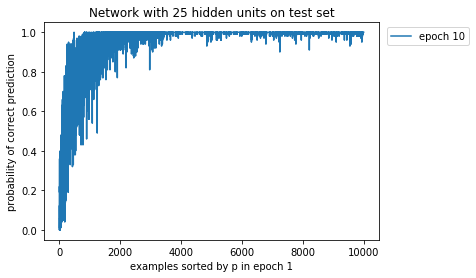

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_opt_paths(num_hidden, num_runs=NUM_RUNS, slurm_id=SLURM_ID, separate_plots=False):
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, num_runs, slurm_id)
    train_opt_ps = opt_paths_to_ordered_ps(train_opt_paths)
    test_opt_ps = opt_paths_to_ordered_ps(test_opt_paths)
    
#     plt.figure()
    for epoch, ps in enumerate(train_opt_ps):
        if separate_plots:
            plt.figure()
        plot_opt_point_probs(ps, 'Network with {} hidden units on training set'.format(num_hidden),
                             xlabel='examples sorted by p in epoch 1', epoch=epoch)
        plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    plt.figure()
    for epoch, ps in enumerate(test_opt_ps):
        if separate_plots:
            plt.figure()
        plot_opt_point_probs(ps, 'Network with {} hidden units on test set'.format(num_hidden),
                             xlabel='examples sorted by p in epoch 1', epoch=epoch)
        plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
# for num_hidden in HIDDEN_SIZES:
#     plot_opt_paths(num_hidden)
plt.close('all')
plot_opt_paths(25, separate_plots=True)

In [7]:
def plot_opt_point_probs(probs, title, xlabel='examples', epoch=None, labels=None):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('probability of correct prediction')
    if epoch is not None:
        label = 'epoch {}'.format(epoch)
    else:
        label = None
    plt.plot(range(len(probs)), probs.tolist(), label=label)

In [4]:
import torch
def get_sorted_probs(bitmaps_list):
    bitmaps = torch.cat(bitmaps_list, dim=1)
    ps = torch.mean(bitmaps, dim=1)
    sorted_ps, idxs = torch.sort(ps)
    return sorted_ps

def opt_paths_to_sorted_ps(opt_paths):
    return [get_sorted_probs(opt_points_i) for opt_points_i in opt_paths]

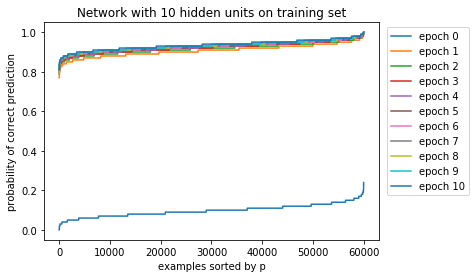

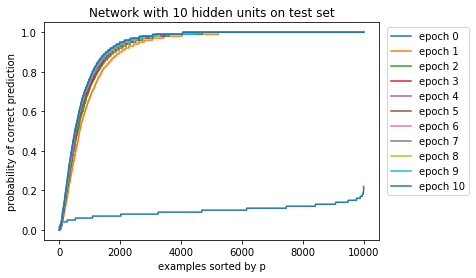

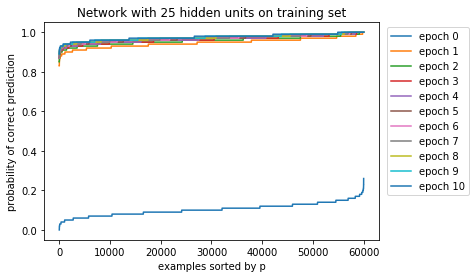

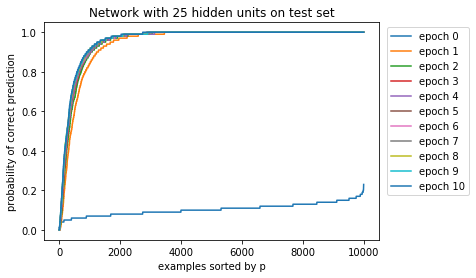

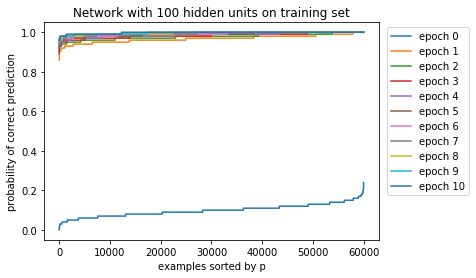

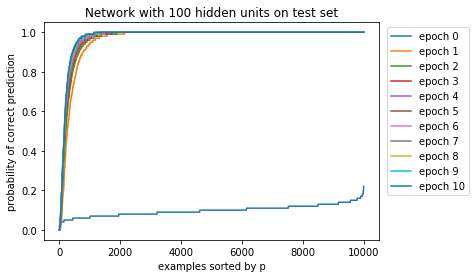

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_sorted_opt_paths(num_hidden, num_runs=NUM_RUNS, slurm_id=SLURM_ID):
    train_opt_paths, test_opt_paths = get_opt_paths(num_hidden, num_runs, slurm_id)
    train_opt_ps = opt_paths_to_sorted_ps(train_opt_paths)
    test_opt_ps = opt_paths_to_sorted_ps(test_opt_paths)
    
    plt.figure()
    for epoch, ps in enumerate(train_opt_ps):
        plot_opt_point_probs(ps, 'Network with {} hidden units on training set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=epoch)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    plt.figure()
    for epoch, ps in enumerate(test_opt_ps):
        plot_opt_point_probs(ps, 'Network with {} hidden units on test set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=epoch)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
for num_hidden in HIDDEN_SIZES:
    plot_sorted_opt_paths(num_hidden)

In [5]:
from fileio import load_fine_path_train_bitmaps, load_fine_path_test_bitmaps

def get_iter_probs(num_hidden, num_runs, i):
    train_bitmaps = [load_fine_path_train_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)]
    test_bitmaps = [load_fine_path_test_bitmaps(num_hidden, run_i, i) for run_i in range(num_runs)]
    return get_sorted_probs(train_bitmaps), get_sorted_probs(test_bitmaps)
    

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_first_epoch(num_hidden, num_runs=100, num_iters=10):
    plt.figure()
    for i in range(num_iters):
        ps, _ = get_iter_probs(num_hidden, num_runs, i)
        plot_opt_point_probs(ps, 'Network with {} hidden units on training set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=(i + 1) / 10)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    
    plt.figure()
    for i in range(num_iters):
        _, ps = get_iter_probs(num_hidden, num_runs, i)
        plot_opt_point_probs(ps, 'Network with {} hidden units on test set'.format(num_hidden),
                             xlabel='examples sorted by p', epoch=(i + 1) / 10)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        
    get_iter_probs(25, 100, 0)

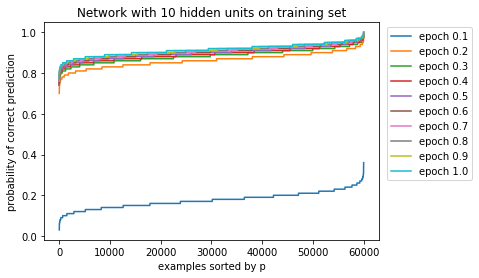

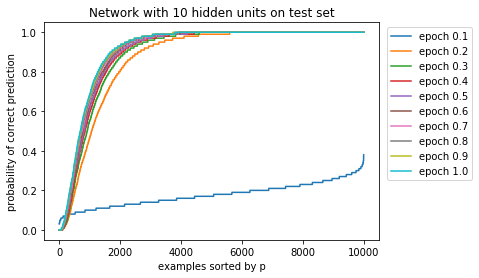

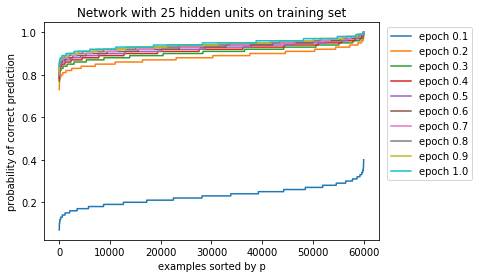

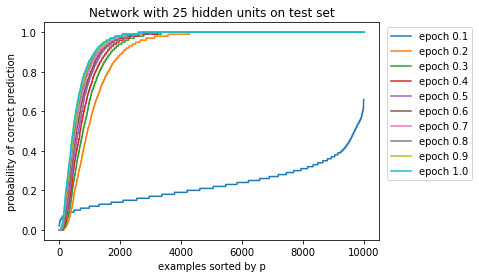

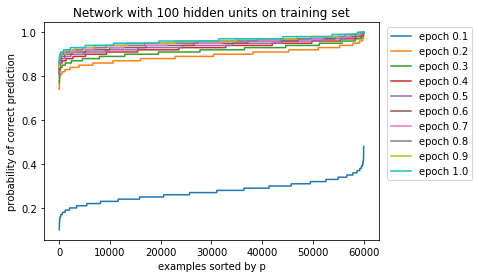

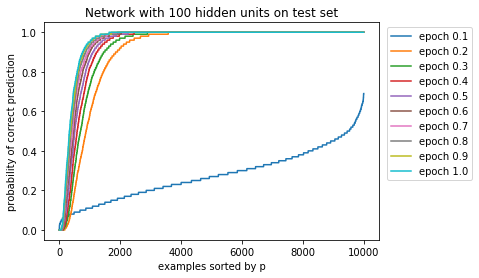

In [13]:
for num_hidden in HIDDEN_SIZES:
    plot_first_epoch(num_hidden)